In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockmarket-sentiment-dataset/stock_data.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [3]:
df=pd.read_csv('/kaggle/input/stockmarket-sentiment-dataset/stock_data.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [4]:
df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [5]:
sentiment_count = Counter(df['Sentiment'])
print(sentiment_count)

Counter({1: 3685, -1: 2106})


# Data Exploration

## Sentiment distribution

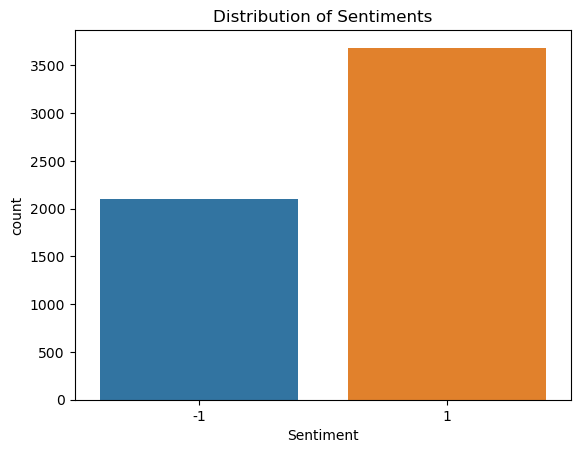

In [6]:
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

## length of the text in my data

In [7]:
df['text_length'] = df['Text'].apply(len)

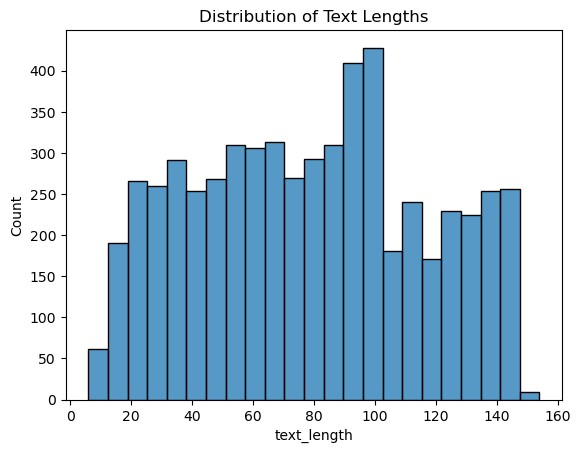

In [8]:
sns.histplot(x='text_length', data=df)
plt.title('Distribution of Text Lengths')
plt.show()

## length of text relation with sentiments

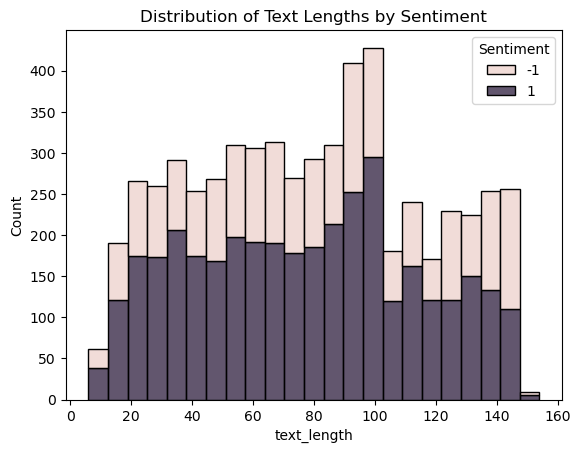

In [9]:
sns.histplot(x='text_length', data=df, hue='Sentiment', multiple='stack')
plt.title('Distribution of Text Lengths by Sentiment')
plt.show()

# Data preprocessing

In [10]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\W', ' ', str(x))) # remove non-alphanumeric characters

In [11]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) # remove single character words

In [12]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\^[a-zA-Z]\s+', ' ', x)) # remove single characters at the beginning of text

In [13]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I)) # replace multiple spaces with single space

In [14]:
df['Text'] = df['Text'].apply(lambda x: x.lower()) # convert to lowercase

In [15]:
#remove stop words and puncuations

nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
df['text_processed'] = df['Text'].apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_stop and not token.is_punct]))


In [16]:
df.head()

,Text,Sentiment,text_length,text_processed
0,kickers on my watchlist xide tit soq pnk cpw b...,1,95,kickers watchlist xide tit soq pnk cpw bpz aj ...
1,user aap movie 55 return for the fea geed indi...,1,95,user aap movie 55 return fea geed indicator 15...
2,user d be afraid to short amzn they are lookin...,1,114,user d afraid short amzn looking like near mon...
3,mnta over 12 00,1,17,mnta 12 00
4,oi over 21 37,1,16,oi 21 37


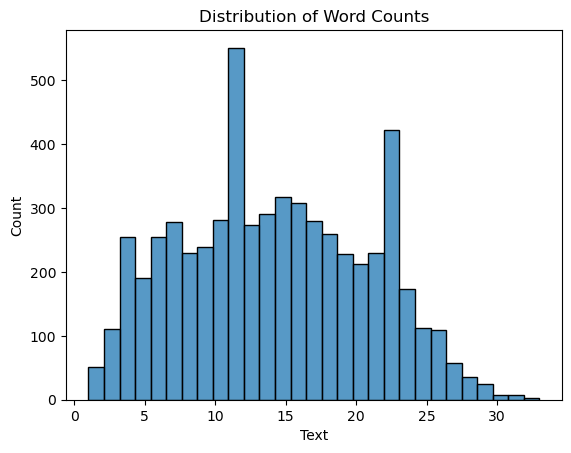

In [17]:
word_count = df['Text'].apply(lambda x: len(x.split()))
sns.histplot(word_count)
plt.title('Distribution of Word Counts')
plt.show()

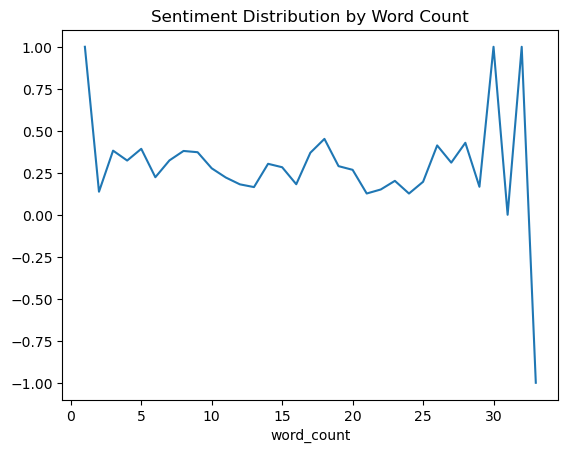

In [18]:
df['word_count'] = word_count
df.groupby('word_count')['Sentiment'].mean().plot()
plt.title('Sentiment Distribution by Word Count')
plt.show()

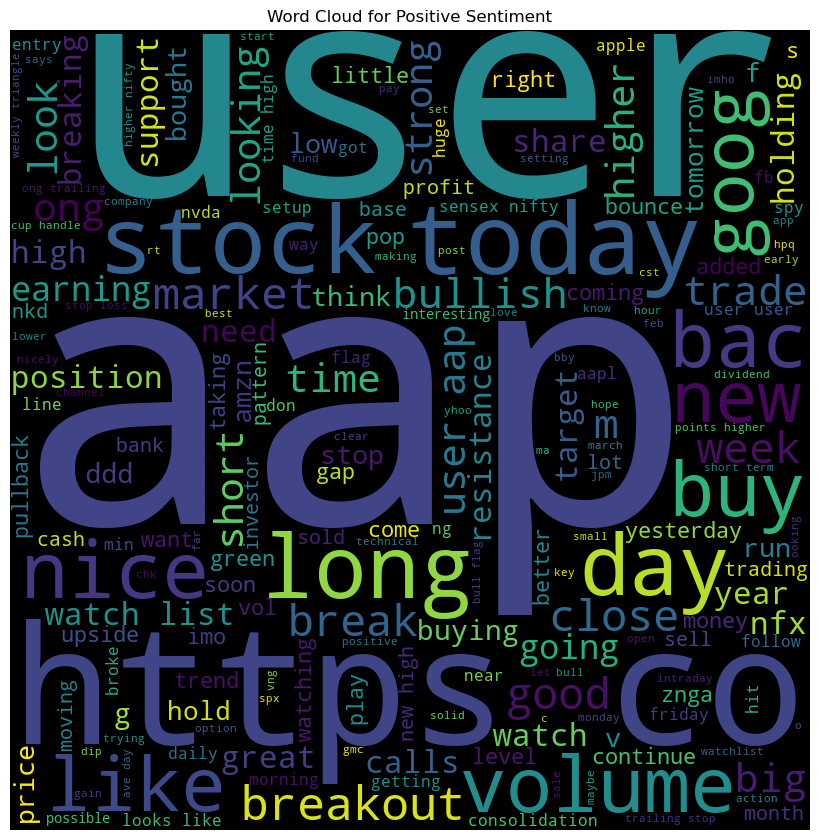

In [19]:
positive_texts = df[df['Sentiment'] == 1]['text_processed']
positive_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(positive_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Positive Sentiment')
plt.show()

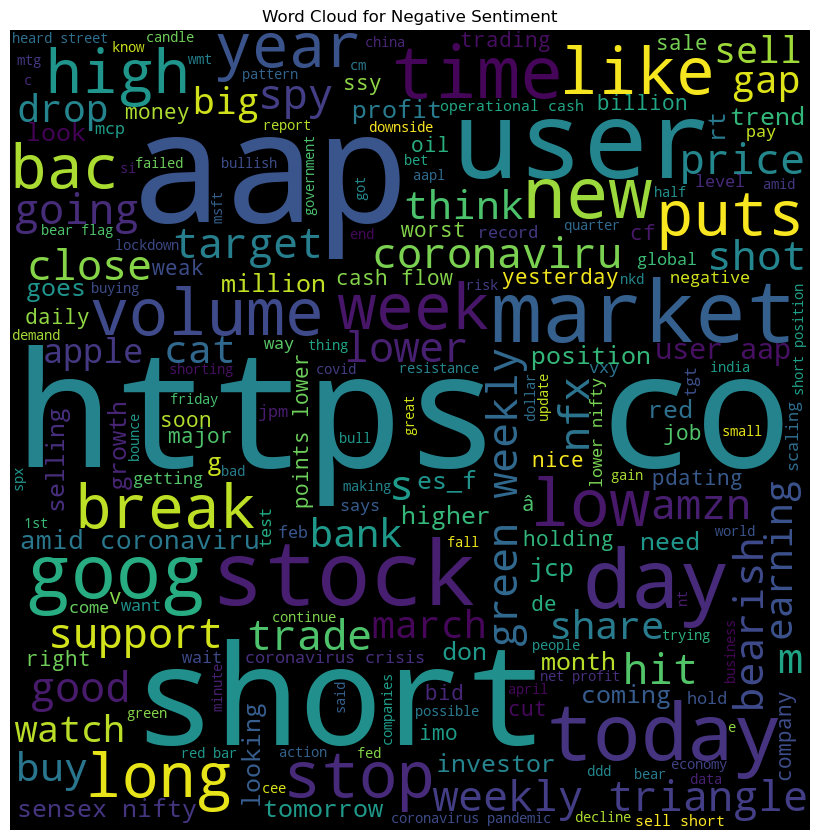

In [20]:
negative_texts = df[df['Sentiment'] == -1]['text_processed']
negative_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(negative_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Negative Sentiment')
plt.show()

## stemming

In [21]:
from nltk.corpus import stopwords

nltk.download('stopwords')
ps = PorterStemmer()
df['Text'] = df['Text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in set(stopwords.words('english'))]))
df['text_processed'] = df['text_processed'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in set(stopwords.words('english'))]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
#randomization
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Text,Sentiment,text_length,text_processed,word_count
0,gmc keep nice consolid make big move soon macd...,1,85,gmc keep nice consolid big soon macd si turn,13
1,vtx option trader buy 3 700 put spread april 4...,-1,113,vtx option trader buy 3 700 spread april 48 42...,24
2,watch dmnd low entri point replac csco state c...,1,130,watch dmnd low entri point replac csco state c...,22
3,user jt miss aap friday would tomorrow buy hod...,1,102,user jt miss aap friday tomorrow buy hod frida...,21
4,aig look entri,1,27,aig look entri,5


## balancing the data

In [23]:

from sklearn.utils import resample

# separate the two classes
df_class1 = df[df['Sentiment'] == 1]
df_class_1 = df[df['Sentiment'] == -1]

# downsample the majority class
df_class1_downsampled = resample(df_class1, replace=False, n_samples=len(df_class_1), random_state=42)

# combine the two classes
df_balanced = pd.concat([df_class1_downsampled, df_class_1])

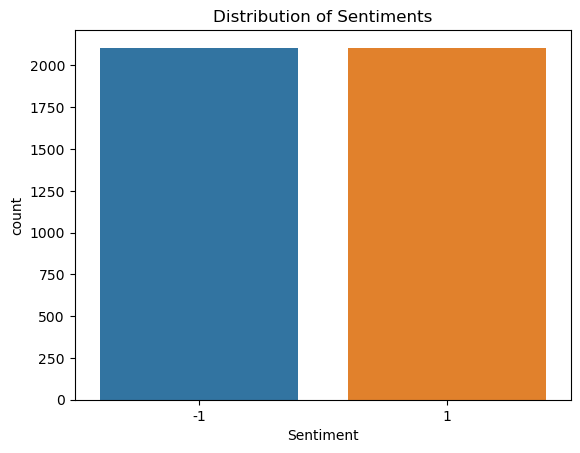

In [24]:
sns.countplot(x='Sentiment', data=df_balanced)
plt.title('Distribution of Sentiments')
plt.show()

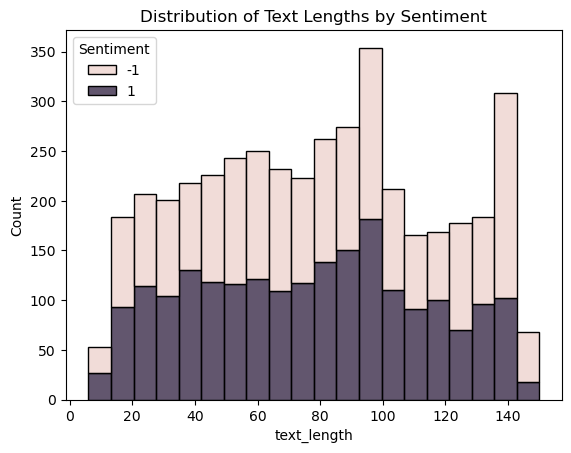

In [25]:
sns.histplot(x='text_length', data=df_balanced, hue='Sentiment', multiple='stack')
plt.title('Distribution of Text Lengths by Sentiment')
plt.show()

# vectorization 

In [26]:
accuracy = {'TF-IDF': [],
            'BoW': []}

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


X = df['Text']
y = df['Sentiment']


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds.round())
accuracy['TF-IDF'].append(lr_acc)


lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_preds = lgr.predict(X_test)
lgr_acc = accuracy_score(y_test, lgr_preds)
accuracy['TF-IDF'].append(lgr_acc)


dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
accuracy['TF-IDF'].append(dt_acc)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
accuracy['TF-IDF'].append(rf_acc)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_preds)
accuracy['TF-IDF'].append(knn_acc)

print(f"Linear Regression Accuracy: {lr_acc}")
print(f"Logistic Regression Accuracy: {lgr_acc}")
print(f"Decision Tree Accuracy: {dt_acc}")
print(f"Random Forest Accuracy: {rf_acc}")
print(f"KNN Accuracy: {knn_acc}")

Linear Regression Accuracy: 0.22346850733390855
Logistic Regression Accuracy: 0.7773943054357204
Decision Tree Accuracy: 0.731665228645384
Random Forest Accuracy: 0.7877480586712683
KNN Accuracy: 0.7618636755823986


In [28]:
model = ['LR','LogR','DT','RF','KNN']
data = {'model':model,'accuracy':accuracy['TF-IDF']}
compare_models = pd.DataFrame(data)
compare_models

,model,accuracy
0,LR,0.223469
1,LogR,0.777394
2,DT,0.731665
3,RF,0.787748
4,KNN,0.761864


### for balanced df

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

X = df_balanced['Text']
y = df_balanced['Sentiment']


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds.round())



lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_preds = lgr.predict(X_test)
lgr_acc = accuracy_score(y_test, lgr_preds)



dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)


rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_preds)


print(f"Linear Regression Accuracy: {lr_acc}")
print(f"Logistic Regression Accuracy: {lgr_acc}")
print(f"Decision Tree Accuracy: {dt_acc}")
print(f"Random Forest Accuracy: {rf_acc}")
print(f"KNN Accuracy: {knn_acc}")

Linear Regression Accuracy: 0.0498220640569395
Logistic Regression Accuracy: 0.7769869513641756
Decision Tree Accuracy: 0.727164887307236
Random Forest Accuracy: 0.7769869513641756
KNN Accuracy: 0.6631079478054567


# hyperparameter tuning

## logistic regression

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
from sklearn.model_selection import GridSearchCV
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]
tfidf = TfidfVectorizer()
tfidf.fit(train_data['Text'])
X_train = tfidf.transform(train_data['Text'])
X_test = tfidf.transform(test_data['Text'])
lr = LogisticRegression()
hyperparameters = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(lr, hyperparameters, cv=5)
grid_search.fit(X_train, train_data['Sentiment'])
best_params = grid_search.best_params_

lr = LogisticRegression(**best_params)
lr.fit(X_train, train_data['Sentiment'])

a = lr.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)
accuracy['TF-IDF'].append(a)

Accuracy: 0.7972389991371872


## Decision Tree

In [32]:
hyperparameters = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15]
}
dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, hyperparameters, cv=5)
grid_search.fit(X_train, train_data['Sentiment'])
best_params = grid_search.best_params_

dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train, train_data['Sentiment'])
a = dt.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)
accuracy['TF-IDF'].append(a)

Accuracy: 0.729076790336497


## random forest 

In [33]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, train_data['Sentiment'])

best_params = grid_search.best_params_
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, train_data['Sentiment'])
a = rf.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)
accuracy['TF-IDF'].append(a)


Accuracy: 0.6496980155306299


## knn

In [34]:
hyperparameters = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, hyperparameters, cv=5)
grid_search.fit(X_train, train_data['Sentiment'])

best_params = grid_search.best_params_

knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, train_data['Sentiment'])
a = knn.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)
accuracy['TF-IDF'].append(a)


Accuracy: 0.7489214840379638


# PLOT FOR VECTORIZATION

In [35]:
accuracy['TF-IDF']

[0.22346850733390855,
 0.7773943054357204,
 0.731665228645384,
 0.7877480586712683,
 0.7618636755823986,
 0.7972389991371872,
 0.729076790336497,
 0.6496980155306299,
 0.7489214840379638]

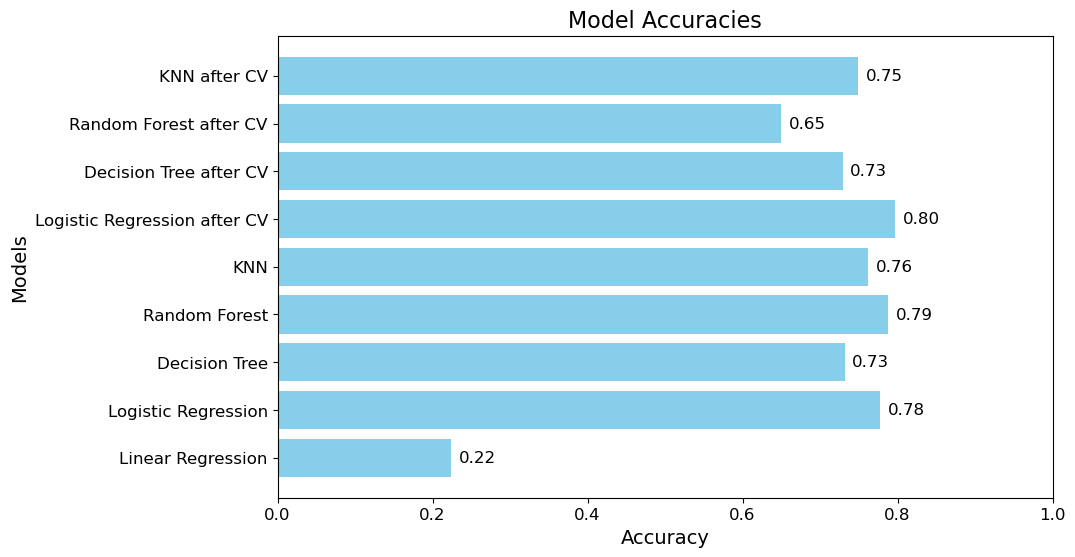

In [36]:
models = ['Linear Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 
          'Logistic Regression after CV', 'Decision Tree after CV', 'Random Forest after CV', 'KNN after CV']
accuracies = accuracy['TF-IDF']
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(models, accuracies, color='skyblue')
ax.set_title('Model Accuracies', fontsize=16)
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_ylabel('Models', fontsize=14)
ax.set_xlim(0, 1)
ax.tick_params(axis='both', labelsize=12)
for i, acc in enumerate(accuracies):
    ax.text(acc+0.01, i, f'{acc:.2f}', va='center', fontsize=12)

plt.show()

# BoW

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = df['Text']
y = df['Sentiment']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds.round())
accuracy['BoW'].append(lr_acc)

lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_preds = lgr.predict(X_test)
lgr_acc = accuracy_score(y_test, lgr_preds)
accuracy['BoW'].append(lgr_acc)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
accuracy['BoW'].append(dt_acc)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
accuracy['BoW'].append(rf_acc)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_preds)
accuracy['BoW'].append(knn_acc)

print(f"Linear Regression Accuracy: {lr_acc}")
print(f"Logistic Regression Accuracy: {lgr_acc}")
print(f"Decision Tree Accuracy: {dt_acc}")
print(f"Random Forest Accuracy: {rf_acc}")
print(f"KNN Accuracy: {knn_acc}")


Linear Regression Accuracy: 0.17687661777394306
Logistic Regression Accuracy: 0.7937877480586712
Decision Tree Accuracy: 0.7299396031061259
Random Forest Accuracy: 0.7860224331320104
KNN Accuracy: 0.6764452113891286


In [38]:
model = ['LR','LogR','DT','RF','KNN']
data = {'model':model,'accuracy':accuracy['BoW']}
compare_models = pd.DataFrame(data)
compare_models

,model,accuracy
0,LR,0.176877
1,LogR,0.793788
2,DT,0.729940
3,RF,0.786022
4,KNN,0.676445


# hyperparameter tuning

## logistic regression

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
X = df['Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
param_grid = {'C': [0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

lr_gs = GridSearchCV(LogisticRegression(), param_grid, cv=5)
lr_gs.fit(X_train_vec, y_train)
accuracy_lr_gs=lr_gs.score(X_test_vec, y_test)
print(f"Tuned Accuracy for lr: {accuracy_lr_gs}")
accuracy['BoW'].append(accuracy_lr_gs)

Tuned Accuracy for lr: 0.7937877480586712


## Decision Tree

In [41]:
X = df['Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
param_grid = {'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
dtc_gs.fit(X_train_vec, y_train)
accuracy_dtc_gs=dtc_gs.score(X_test_vec, y_test)
print(f"Tuned Accuracy for dtc: {accuracy_dtc_gs}")
accuracy['BoW'].append(accuracy_dtc_gs)

Tuned Accuracy for dtc: 0.7368421052631579


## random forest 

In [42]:
from sklearn.ensemble import RandomForestClassifier
X = df['Text']
y = df['Sentiment']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)


print('Best Hyperparameters:', grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy_rf_cv = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy_rf_cv*100))
accuracy['BoW'].append(accuracy_rf_cv)

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 64.71%


## knn

In [43]:
from sklearn.neighbors import KNeighborsClassifier
X = df['Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

param_grid = {'n_neighbors': [5, 10, 15, 20],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30],
              'p': [1, 2]}

knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn_gs.fit(X_train_vec, y_train)

accuracy_knn_gs = knn_gs.score(X_test_vec, y_test)
print(f"Tuned Accuracy: {accuracy_knn_gs}")
accuracy['BoW'].append(accuracy_knn_gs)

Tuned Accuracy: 0.6833477135461605


# PLOT OF ALL MODELS

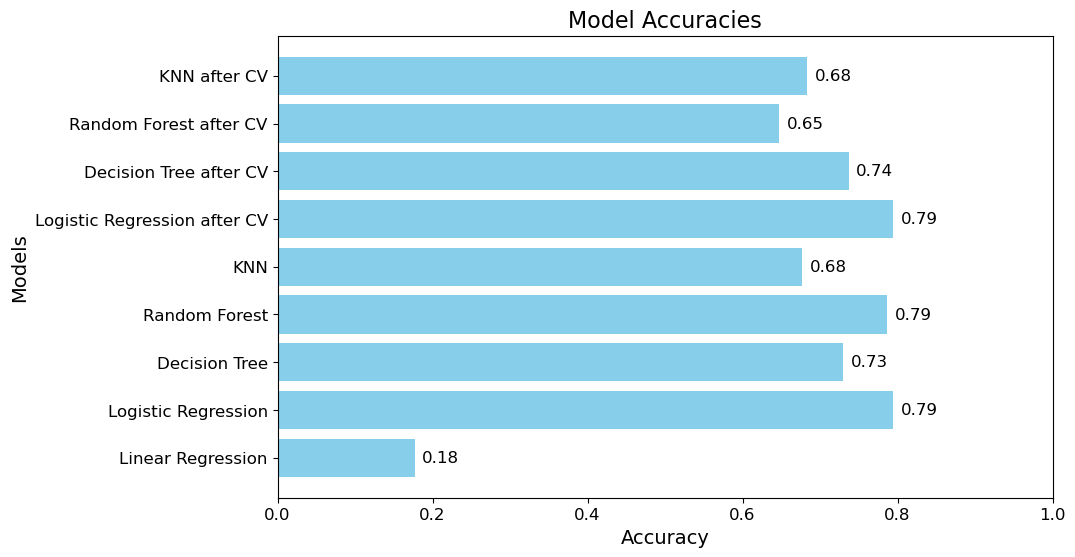

In [44]:
models = ['Linear Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 
          'Logistic Regression after CV', 'Decision Tree after CV', 'Random Forest after CV', 'KNN after CV']
accuracies = accuracy['BoW']
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(models, accuracies, color='skyblue')
ax.set_title('Model Accuracies', fontsize=16)
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_ylabel('Models', fontsize=14)
ax.set_xlim(0, 1)
ax.tick_params(axis='both', labelsize=12)
for i, acc in enumerate(accuracies):
    ax.text(acc+0.01, i, f'{acc:.2f}', va='center', fontsize=12)

plt.show()

## comparision of both technique

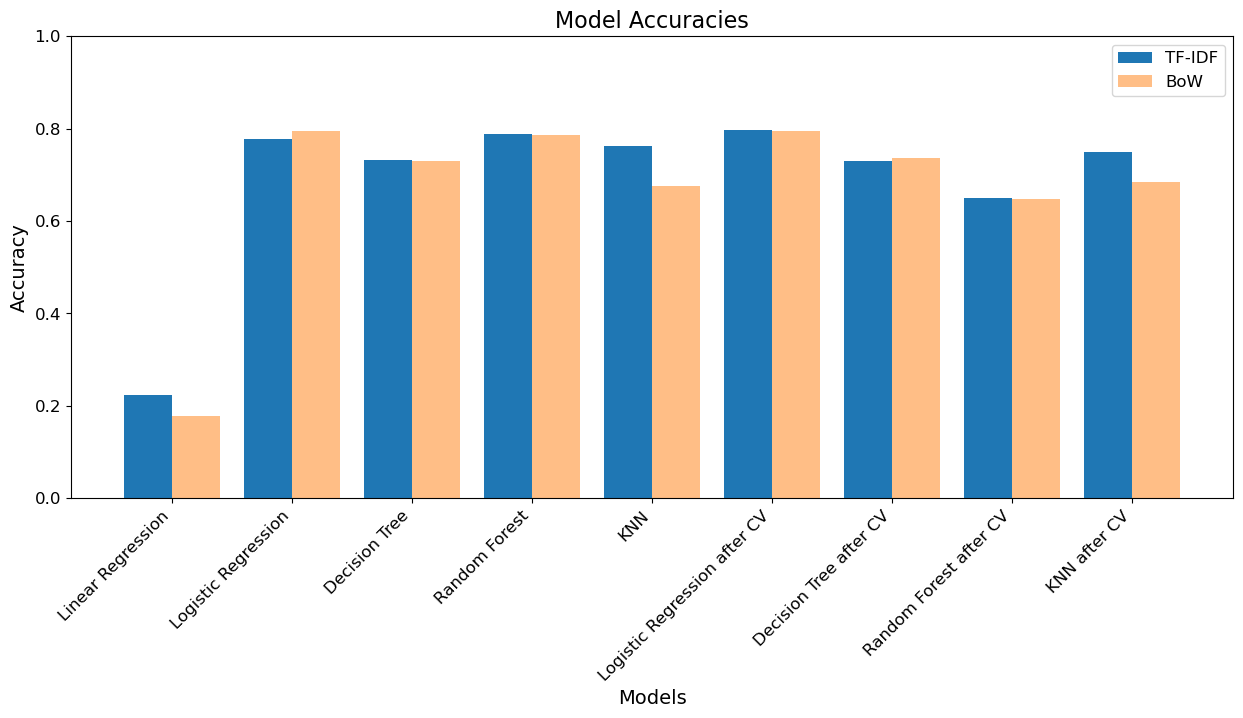

In [45]:

models = ['Linear Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN',           'Logistic Regression after CV', 'Decision Tree after CV', 'Random Forest after CV', 'KNN after CV']

tfidf_acc = accuracy['TF-IDF']
bow_acc = accuracy['BoW']

x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(x - 0.2, tfidf_acc, width=0.4, label='TF-IDF')
ax.bar(x + 0.2, bow_acc, width=0.4, label='BoW', alpha=0.5)
ax.set_title('Model Accuracies', fontsize=16)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.xticks(x, models, rotation=45, ha='right')
plt.show()


# CONCLUSION 

**We evaluated five different machine learning models on a stock market sentiment analysis dataset, and the results showed that the vectorization and bag of words strategies produced good accuracy levels. We used the decision tree, random forest, KNN, logistic regression, and linear regression techniques. For each model, we have optimized the performance using hyperparameter tuning.**

**We used the Term Frequency-Inverse Document Frequency (TF-IDF) method for the vectorization technique and the Count Vectorization for the bag of words method. The model trained using the vectorization strategy with the highest accuracy was Random Forest (79%).**
